In [10]:
from model_builder import ModelBuilder
from sklearn.linear_model import Lasso, Ridge, LassoCV, RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import json
import os
from model_utils import *
import scipy.stats as stats 

## Model Deep Dive: CSOP

Using the CSOP Dataset, build a model that progressively accounts for different aspects of the data...

Team Composition:
- skill
- social_perceptivness
- cogStyleDiversity
- cogStyleSpeed

Task Features:
- complexity

Conversation Features (All)

In [11]:
# PARAMETERS
min_num_chats = 0
desired_target = "efficiency"
data_path = "../output/"
output_path = "./results/csopII/" + "min=" + str(min_num_chats) + "/" + desired_target + "/"
validation_results_output_name = output_path + "csopII_lasso_ridge_experiments" + "_" + desired_target + "_min_chat_num_" + str(min_num_chats) + ".csv"
test_results_output_name = output_path + "csopII_lasso_ridge_experiments" + "_" + desired_target + "_min_chat_num_" + str(min_num_chats) + "_CSOP_out_of_sample_test" + ".csv"

In [12]:
def read_and_preprocess_data(path, min_num_chats):
    csop_conv_data  = pd.read_csv(path)

    # Filter this down to teams that have at least min_num of chats
    # Can also comment this out to re-run results on *all* conversations!
    csop_conv_data = csop_conv_data[csop_conv_data["sum_num_messages"] >= min_num_chats]

    # Save the important information

    # Task and Composition features
    csop_conv_data["difficulty"] = csop_conv_data["difficulty"].map({
        "Easy [Corresponds to 'Hard' in PNAS]": "Moderate",
        "Hard [Corresponds to 'Super Hard' in PNAS]": "Very high"
    })
    task_features = pd.get_dummies(csop_conv_data["difficulty"])
    team_composition_features =  pd.get_dummies(csop_conv_data[["vis_img", "int_verb", "ort_img", "rep_man", "soc_pers", "team_size"]])

    # possible targets to try
    targets = csop_conv_data[["efficiency","score","duration"]]

    # Read in the config file and use that the drop the extraneous columns
    with open('./config.json', "rb") as json_file:
        config = json.load(json_file)

    conv_features = csop_conv_data.drop(config["csopII"]['cols_to_ignore'], axis = 1)

    # Normalization
    team_composition_features = pd.DataFrame(StandardScaler().fit_transform(team_composition_features), columns = team_composition_features.columns)
    conv_features = pd.DataFrame(StandardScaler().fit_transform(conv_features), columns = conv_features.columns)
    # drop na cols
    conv_features = conv_features.dropna(axis = 1)

    targets = pd.DataFrame(StandardScaler().fit_transform(targets), columns = targets.columns)

    return team_composition_features, task_features, conv_features, targets

In [13]:
team_composition_features, task_features, conv_features, targets = read_and_preprocess_data(data_path + 'conv/csopII_output_conversation_level.csv', min_num_chats=min_num_chats)

In [14]:
# Number of points in dataset
len(conv_features)

962

## Train-Test Split

In [15]:
X = pd.concat([task_features.reset_index(drop=True), team_composition_features.reset_index(drop=True), conv_features.reset_index(drop=True)], axis=1)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, targets, random_state=42, test_size=0.2)

## Try LASSO/Ridge Regression, one Set of Features at a Time

Here, we want to implement *leave-one-out cross-validation*, and use Q^2 as our metric.



In [17]:
# Note --- this uses k-fold cross-validation with k = 5 (the default)
# We are testing 10,000 different alphas, so I feel like this is an OK heuristic
def get_optimal_alpha(y_target, feature_columns_list, lasso):

    if(lasso == True):
        model = LassoCV(n_alphas = 10000)
        model.fit(X_train[feature_columns_list], y_train[y_target])
    else:
        model = RidgeCV(n_alphas = 10000)
        model.fit(X_train[feature_columns_list], y_train[y_target])
        
    return model.alpha_ # optimal alpha

In [18]:
def fit_regularized_linear_model(y_target, feature_columns_list, lasso=True, tune_alpha=False):

    if not tune_alpha:
        alpha = 1.0
    else:
        # Hyperparameter tune the alpha
        alpha = get_optimal_alpha(y_target, feature_columns_list, lasso=True)

    if lasso:
        model = Lasso(alpha=alpha)
    else:
        model = Ridge(alpha=alpha)

    # Calculation of Q^2 metric
    squared_model_prediction_errors = []
    squared_average_prediction_errors = []

    # Initialize a list to store coefficients
    coefficients_list = []

    # Leave one out -- iterate through the entire length of the dataset
    for i in range(len(y_train)):
        # Store the evaluation datapoint
        evaluation_X = X_train.iloc[[i]]
        evaluation_y = y_train.iloc[[i]][y_target]

        # Drop the ith datapoint (leave this one out)
        X_train_fold = X_train.drop(X_train.index[i])
        y_train_fold = y_train.drop(y_train.index[i])[y_target]

        # Fit the model
        model.fit(X_train_fold[feature_columns_list], y_train_fold)

        # Save the Prediction Error
        prediction = model.predict(evaluation_X[feature_columns_list])[0]
        squared_model_prediction_errors.append((evaluation_y - prediction) ** 2)

        # Save the Total Error for this fold
        squared_average_prediction_errors.append((evaluation_y - np.mean(y_train_fold)) ** 2)

        # Append the coefficients to the list
        coefficients_list.append(model.coef_)

    # Create a DataFrame with feature names as rows and iteration results as columns
    feature_coefficients = pd.DataFrame(coefficients_list, columns=feature_columns_list).T

    q_squared = 1 - (np.sum(squared_model_prediction_errors) / np.sum(squared_average_prediction_errors))
    print("Q^2: " + str(q_squared))

    return model, q_squared, feature_coefficients


In [19]:
def display_feature_coefficients(feature_coef_df):
    # Initialize a list to store DataFrames for each feature
    dfs = []

    # Iterate through the rows of the input DataFrame
    for feature_name, coefficients in feature_coef_df.iterrows():
        # Calculate the confidence interval without NaN values
        non_nan_coefficients = coefficients[~np.isnan(coefficients)]
        if len(non_nan_coefficients) == 0:
            # Handle the case where there are no valid coefficients
            continue

        mean_coef = non_nan_coefficients.mean()

        # Check if all coefficients in the row are the same
        if len(coefficients.unique()) == 1:
            # If all coefficients are the same, set the lower and upper CI to the mean
            confidence_interval = (mean_coef, mean_coef)
        else:
            std_error = non_nan_coefficients.sem()
            confidence_interval = stats.t.interval(0.95, len(non_nan_coefficients) - 1, loc=mean_coef, scale=std_error)

        # Create a DataFrame for the summary data
        temp_df = pd.DataFrame({
            "Feature": [feature_name],
            "Mean": [mean_coef],
            "Lower_CI": [confidence_interval[0]],
            "Upper_CI": [confidence_interval[1]]
        })

        # Append the temporary DataFrame to the list
        dfs.append(temp_df)

    # Concatenate all the DataFrames in the list into the final summary DataFrame
    summary_df = pd.concat(dfs, ignore_index=True)

    return summary_df

In [20]:
def sort_by_mean_abs(df):
    return df.reindex(df["Mean"].abs().sort_values(ascending=False).index)

In [21]:
# Go through the different types of features and fit models

# First, create a data structure that saves the result
result = {
    "model": [],
    "model_type": [],
    "features_included": [],
    "alpha": [],
    "q_squared": []
}

result_df = pd.DataFrame(result)

## Team composition features

In [22]:
model_ridge_composition, mrc_q2, mrc_feature_coefficients = fit_regularized_linear_model(desired_target, team_composition_features.columns, lasso = False, tune_alpha = True)

result_df = pd.concat([result_df, pd.DataFrame({"model": [model_ridge_composition], "model_type": ["Ridge"], "features_included": ["Team Composition"], "alpha": [model_ridge_composition.alpha.round(4)], "q_squared": [mrc_q2]})], ignore_index=True)

Q^2: 0.013753509748307025


In [23]:
directory = os.path.dirname(output_path + 'mrc_feature_coefficients' + '.csv')
if not os.path.exists(directory):
    os.makedirs(directory)
mrc_feature_coefficients.to_csv(output_path + 'mrc_feature_coefficients' + '.csv')

In [24]:
sort_by_mean_abs(display_feature_coefficients(mrc_feature_coefficients))

,Feature,Mean,Lower_CI,Upper_CI
0,team_size,0.169006,0.168900,0.169111
9,ort_img_Mixed,0.080545,0.080460,0.080630
6,int_verb_Mixed,-0.052573,-0.052642,-0.052505
8,ort_img_Low,-0.035328,-0.035386,-0.035271
15,soc_pers_Mixed,-0.029254,-0.029327,-0.029180
4,int_verb_High,0.025581,0.025522,0.025641
7,ort_img_High,-0.023938,-0.024001,-0.023875
5,int_verb_Low,0.019542,0.019474,0.019610
14,soc_pers_Low,0.019478,0.019420,0.019536
11,rep_man_Low,0.016600,0.016533,0.016667


In [25]:
model_lasso_composition, mlc_q2, mlc_feature_coefficients = fit_regularized_linear_model(desired_target, team_composition_features.columns, lasso = True, tune_alpha = True)
result_df = pd.concat([result_df, pd.DataFrame({"model": [model_lasso_composition], "model_type": ["Lasso"], "features_included": ["Team Composition"], "alpha": [model_lasso_composition.alpha.round(4)], "q_squared": [mlc_q2]})], ignore_index=True)

Q^2: 0.02411373150849938


In [26]:
directory = os.path.dirname(output_path + 'mlc_feature_coefficients' + '.csv')
if not os.path.exists(directory):
    os.makedirs(directory)
mlc_feature_coefficients.to_csv(output_path + 'mlc_feature_coefficients' + '.csv')

## Task Features

In [27]:
model_ridge_task, mrt_q2, mrt_feature_coefficients = fit_regularized_linear_model(desired_target, task_features.columns, lasso = False, tune_alpha = True)
result_df = pd.concat([result_df, pd.DataFrame({"model": [model_ridge_task], "model_type": ["Ridge"], "features_included": ["Task Complexity"], "alpha": [model_ridge_task.alpha.round(4)], "q_squared": [mrt_q2]})], ignore_index=True)

Q^2: -0.0024401993964380253


In [28]:
directory = os.path.dirname(output_path + 'mrt_feature_coefficients' + '.csv')
if not os.path.exists(directory):
    os.makedirs(directory)
mrt_feature_coefficients.to_csv(output_path + 'mrt_feature_coefficients' + '.csv')

In [29]:
sort_by_mean_abs(display_feature_coefficients(mrt_feature_coefficients))

,Feature,Mean,Lower_CI,Upper_CI
1,Very high,0.012964,0.012871,0.013057
0,Moderate,-0.012964,-0.013057,-0.012871


In [30]:
model_lasso_task, mlt_q2, mlt_feature_coefficients = fit_regularized_linear_model(desired_target, task_features.columns, lasso = True, tune_alpha = True)
result_df = pd.concat([result_df, pd.DataFrame({"model": [model_lasso_task], "model_type": ["Lasso"], "features_included": ["Task Complexity"], "alpha": [model_lasso_task.alpha.round(4)], "q_squared": [mlt_q2]})], ignore_index=True)

Q^2: -0.0013405321672208537


In [31]:
directory = os.path.dirname(output_path + 'mlt_feature_coefficients' + '.csv')
if not os.path.exists(directory):
    os.makedirs(directory)
mlt_feature_coefficients.to_csv(output_path + 'mlt_feature_coefficients' + '.csv')

In [32]:
sort_by_mean_abs(display_feature_coefficients(mlt_feature_coefficients))

,Feature,Mean,Lower_CI,Upper_CI
0,Moderate,-1.030170e-03,-1.142762e-03,-9.175790e-04
1,Very high,5.925583e-18,4.939771e-18,6.911394e-18


## Task + Composition Together

In [33]:
task_comp_features = list(task_features.columns) + list(team_composition_features.columns)

model_ridge_taskcomp, mrtc_q2, mrtc_feature_coefficients = fit_regularized_linear_model(desired_target, task_comp_features, lasso = False, tune_alpha = True)
result_df = pd.concat([result_df, pd.DataFrame({"model": [model_ridge_taskcomp], "model_type": ["Ridge"], "features_included": ["Team Composition + Task Complexity"], "alpha": [model_ridge_taskcomp.alpha.round(4)], "q_squared": [mrtc_q2]})], ignore_index=True)

Q^2: 0.011361014399293823


In [34]:
directory = os.path.dirname(output_path + 'mrtc_feature_coefficients' + '.csv')
if not os.path.exists(directory):
    os.makedirs(directory)
mrtc_feature_coefficients.to_csv(output_path + 'mrtc_feature_coefficients' + '.csv')

In [35]:
sort_by_mean_abs(display_feature_coefficients(mrtc_feature_coefficients))

,Feature,Mean,Lower_CI,Upper_CI
2,team_size,0.168899,0.168793,0.169005
11,ort_img_Mixed,0.080687,0.080602,0.080772
8,int_verb_Mixed,-0.053050,-0.053119,-0.052981
10,ort_img_Low,-0.035277,-0.035334,-0.035219
17,soc_pers_Mixed,-0.029179,-0.029253,-0.029105
6,int_verb_High,0.025781,0.025721,0.025841
9,ort_img_High,-0.024100,-0.024163,-0.024037
7,int_verb_Low,0.019756,0.019688,0.019824
16,soc_pers_Low,0.019548,0.019490,0.019606
13,rep_man_Low,0.016589,0.016522,0.016657


In [36]:
model_lasso_taskcomp, mltc_q2, mltc_feature_coefficients = fit_regularized_linear_model(desired_target, task_comp_features, lasso = True, tune_alpha = True)
result_df = pd.concat([result_df, pd.DataFrame({"model": [model_lasso_taskcomp], "model_type": ["Lasso"], "features_included": ["Team Composition + Task Complexity"], "alpha": [model_lasso_taskcomp.alpha.round(4)], "q_squared": [mltc_q2]})], ignore_index=True)

Q^2: 0.02411373150849938


In [37]:
directory = os.path.dirname(output_path + 'mltc_feature_coefficients' + '.csv')
if not os.path.exists(directory):
    os.makedirs(directory)
mltc_feature_coefficients.to_csv(output_path + 'mltc_feature_coefficients' + '.csv')

In [38]:
sort_by_mean_abs(display_feature_coefficients(mltc_feature_coefficients))

,Feature,Mean,Lower_CI,Upper_CI
2,team_size,0.142322,0.142223,0.142421
11,ort_img_Mixed,0.060149,0.060044,0.060255
8,int_verb_Mixed,-0.039737,-0.039825,-0.039649
17,soc_pers_Mixed,-0.004357,-0.004445,-0.004270
16,soc_pers_Low,0.001567,0.001489,0.001644
10,ort_img_Low,-0.000034,-0.000051,-0.000017
15,soc_pers_High,0.000000,0.000000,0.000000
14,rep_man_Mixed,0.000000,0.000000,0.000000
13,rep_man_Low,0.000000,0.000000,0.000000
12,rep_man_High,0.000000,0.000000,0.000000


## Conversation Alone

In [39]:
model_lasso_comms, mlcom_q2, mlcom_feature_coefficients = fit_regularized_linear_model(desired_target, conv_features.columns, lasso = True, tune_alpha = True)
result_df = pd.concat([result_df, pd.DataFrame({"model": [model_lasso_comms], "model_type": ["Lasso"], "features_included": ["Communication"], "alpha": [model_lasso_comms.alpha.round(4)], "q_squared": [mlcom_q2]})], ignore_index=True)

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.503e-02, tolerance: 6.636e-02
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.762e-02, tolerance: 6.636e-02
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.941e-02, tolerance: 6.636e-02
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.872e-02, tolerance: 6.636e-02
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.863e-02, tolerance: 6.636e-02
Objective did n

Q^2: 0.16748445492796338


In [40]:
directory = os.path.dirname(output_path + 'mlcom_feature_coefficients' + '.csv')
if not os.path.exists(directory):
    os.makedirs(directory)
mlcom_feature_coefficients.to_csv(output_path + 'mlcom_feature_coefficients' + '.csv')

In [41]:
sort_by_mean_abs(display_feature_coefficients(mlcom_feature_coefficients))

,Feature,Mean,Lower_CI,Upper_CI
653,max_user_sum_time_diff,-0.124482,-0.124579,-0.124384
52,stdev_adverbs,-0.098997,-0.099164,-0.098831
835,stdev_user_avg_positive_affect,0.045066,0.044923,0.045209
379,stdev_user_sum_num_messages,-0.044804,-0.044917,-0.044690
936,min_user_avg_auxiliary_verbs,-0.044245,-0.044413,-0.044076
...,...,...,...,...
407,stdev_user_sum_certainty,0.000000,0.000000,0.000000
408,min_user_sum_certainty,0.000000,0.000000,0.000000
409,max_user_sum_certainty,0.000000,0.000000,0.000000
410,average_user_sum_inclusive,0.000000,0.000000,0.000000


In [42]:
model_ridge_comms, mrcom_q2, mrcom_feature_coefficients = fit_regularized_linear_model(desired_target, conv_features.columns, lasso = False, tune_alpha = True)
result_df = pd.concat([result_df, pd.DataFrame({"model": [model_ridge_comms], "model_type": ["Ridge"], "features_included": ["Communication"], "alpha": [model_ridge_comms.alpha.round(4)], "q_squared": [mrcom_q2]})], ignore_index=True)

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.503e-02, tolerance: 6.636e-02
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.762e-02, tolerance: 6.636e-02
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.941e-02, tolerance: 6.636e-02
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.872e-02, tolerance: 6.636e-02
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.863e-02, tolerance: 6.636e-02
Objective did n

Q^2: -6.715209396529517


In [43]:
directory = os.path.dirname(output_path + 'mrcom_feature_coefficients' + '.csv')
if not os.path.exists(directory):
    os.makedirs(directory)
mrcom_feature_coefficients.to_csv(output_path + 'mrcom_feature_coefficients' + '.csv')

In [44]:
sort_by_mean_abs(display_feature_coefficients(mrcom_feature_coefficients))

,Feature,Mean,Lower_CI,Upper_CI
185,min_verbs,-0.779698,-0.783092,-0.776305
205,min_cognitive_mech,-0.722188,-0.724233,-0.720143
942,average_user_avg_preposition,-0.695479,-0.697483,-0.693474
1,gini_coefficient_sum_num_chars,-0.681944,-0.684752,-0.679137
207,average_preposition,-0.680229,-0.682394,-0.678065
...,...,...,...,...
443,stdev_user_sum_death,0.000000,0.000000,0.000000
444,min_user_sum_death,0.000000,0.000000,0.000000
445,max_user_sum_death,0.000000,0.000000,0.000000
456,min_user_sum_body,0.000000,0.000000,0.000000


## Conversation Features + Task Features

In [45]:
convtask_features = list(task_features.columns) + list(conv_features.columns)
model_lasso_tconv, mltconv_q2, mltconv_feature_coefficients = fit_regularized_linear_model(desired_target, convtask_features, lasso = True, tune_alpha = True)
result_df = pd.concat([result_df, pd.DataFrame({"model": [model_lasso_tconv], "model_type": ["Lasso"], "features_included": ["Task Complexity + Communication"], "alpha": [model_lasso_tconv.alpha.round(4)], "q_squared": [mltconv_q2]})], ignore_index=True)

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.796e-02, tolerance: 6.636e-02
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.649e-02, tolerance: 6.636e-02
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.042e-02, tolerance: 6.636e-02
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.123e-02, tolerance: 6.636e-02
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.659e-02, tolerance: 6.636e-02
Objective did n

Q^2: 0.16748445492796338


In [46]:
directory = os.path.dirname(output_path + 'mltconv_feature_coefficients' + '.csv')
if not os.path.exists(directory):
    os.makedirs(directory)
mltconv_feature_coefficients.to_csv(output_path + 'mltconv_feature_coefficients' + '.csv')

In [47]:
sort_by_mean_abs(display_feature_coefficients(mltconv_feature_coefficients))

,Feature,Mean,Lower_CI,Upper_CI
655,max_user_sum_time_diff,-0.124482,-0.124579,-0.124384
54,stdev_adverbs,-0.098997,-0.099164,-0.098831
837,stdev_user_avg_positive_affect,0.045066,0.044923,0.045209
381,stdev_user_sum_num_messages,-0.044804,-0.044917,-0.044690
938,min_user_avg_auxiliary_verbs,-0.044245,-0.044413,-0.044076
...,...,...,...,...
408,average_user_sum_certainty,0.000000,0.000000,0.000000
409,stdev_user_sum_certainty,0.000000,0.000000,0.000000
410,min_user_sum_certainty,0.000000,0.000000,0.000000
411,max_user_sum_certainty,0.000000,0.000000,0.000000


In [48]:
model_ridge_tconv, mrtconv_q2, mrtconv_feature_coefficients = fit_regularized_linear_model(desired_target, convtask_features, lasso = False, tune_alpha = True)
result_df = pd.concat([result_df, pd.DataFrame({"model": [model_ridge_tconv], "model_type": ["Ridge"], "features_included": ["Task Complexity + Communication"], "alpha": [model_ridge_tconv.alpha.round(4)], "q_squared": [mrtconv_q2]})], ignore_index=True)

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.796e-02, tolerance: 6.636e-02
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.649e-02, tolerance: 6.636e-02
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.042e-02, tolerance: 6.636e-02
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.123e-02, tolerance: 6.636e-02
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.659e-02, tolerance: 6.636e-02
Objective did n

Q^2: -7.532778236686603


In [49]:
directory = os.path.dirname(output_path + 'mrtconv_feature_coefficients' + '.csv')
if not os.path.exists(directory):
    os.makedirs(directory)
mrtconv_feature_coefficients.to_csv(output_path + 'mrtconv_feature_coefficients' + '.csv')

In [50]:
sort_by_mean_abs(display_feature_coefficients(mrtconv_feature_coefficients))

,Feature,Mean,Lower_CI,Upper_CI
187,min_verbs,-0.774681,-0.778351,-0.771011
207,min_cognitive_mech,-0.763879,-0.766078,-0.761680
944,average_user_avg_preposition,-0.711693,-0.713842,-0.709544
209,average_preposition,-0.704914,-0.707231,-0.702597
3,gini_coefficient_sum_num_chars,-0.703433,-0.706408,-0.700457
...,...,...,...,...
446,min_user_sum_death,0.000000,0.000000,0.000000
445,stdev_user_sum_death,0.000000,0.000000,0.000000
444,average_user_sum_death,0.000000,0.000000,0.000000
442,min_user_sum_swear,0.000000,0.000000,0.000000


## Model with All Features

In [51]:
all_features = list(task_features.columns) + list(team_composition_features.columns) + list(conv_features.columns)
model_lasso_all, mlall_q2, mlall_feature_coefficients = fit_regularized_linear_model(desired_target, all_features, lasso = True, tune_alpha = True)
result_df = pd.concat([result_df, pd.DataFrame({"model": [model_lasso_all], "model_type": ["Lasso"], "features_included": ["All Features"], "alpha": [model_lasso_all.alpha.round(4)], "q_squared": [mlall_q2]})], ignore_index=True)


Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.738e-02, tolerance: 6.636e-02
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.456e-02, tolerance: 6.636e-02
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.639e-02, tolerance: 6.636e-02
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.508e-02, tolerance: 6.636e-02
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.335e-02, tolerance: 6.636e-02
Objective did n

Q^2: 0.28749220282542054


In [52]:
directory = os.path.dirname(output_path + 'mlall_feature_coefficients' + '.csv')
if not os.path.exists(directory):
    os.makedirs(directory)
mlall_feature_coefficients.to_csv(output_path + 'mlall_feature_coefficients' + '.csv')

In [53]:
sort_by_mean_abs(display_feature_coefficients(mlall_feature_coefficients))

,Feature,Mean,Lower_CI,Upper_CI
2,team_size,0.412409,0.412285,0.412534
387,sum_num_messages,-0.156756,-0.156859,-0.156653
20,gini_coefficient_sum_num_messages,-0.107893,-0.108017,-0.107769
70,stdev_adverbs,-0.087433,-0.087572,-0.087293
671,max_user_sum_time_diff,-0.066580,-0.066674,-0.066486
...,...,...,...,...
428,average_user_sum_inclusive,0.000000,0.000000,0.000000
429,stdev_user_sum_inclusive,0.000000,0.000000,0.000000
430,min_user_sum_inclusive,0.000000,0.000000,0.000000
431,max_user_sum_inclusive,0.000000,0.000000,0.000000


In [54]:
model_ridge_all, mrall_q2, mrall_feature_coefficients = fit_regularized_linear_model(desired_target, all_features, lasso = False, tune_alpha = True)
result_df = pd.concat([result_df, pd.DataFrame({"model": [model_ridge_all], "model_type": ["Ridge"], "features_included": ["All Features"], "alpha": [model_ridge_all.alpha.round(4)], "q_squared": [mrall_q2]})], ignore_index=True)

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.738e-02, tolerance: 6.636e-02
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.456e-02, tolerance: 6.636e-02
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.639e-02, tolerance: 6.636e-02
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.508e-02, tolerance: 6.636e-02
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.335e-02, tolerance: 6.636e-02
Objective did n

Q^2: -5.895211899108977


In [55]:
directory = os.path.dirname(output_path + 'mrall_feature_coefficients' + '.csv')
if not os.path.exists(directory):
    os.makedirs(directory)
mrall_feature_coefficients.to_csv(output_path + 'mrall_feature_coefficients' + '.csv')

In [56]:
sort_by_mean_abs(display_feature_coefficients(mrall_feature_coefficients))

,Feature,Mean,Lower_CI,Upper_CI
203,min_verbs,-0.830631,-0.833982,-0.827279
898,min_user_avg_indefinite_pronoun,-0.777769,-0.779932,-0.775607
113,average_quantifier,-0.755408,-0.757109,-0.753706
223,min_cognitive_mech,-0.740754,-0.742727,-0.738781
19,gini_coefficient_sum_num_chars,-0.662656,-0.665214,-0.660098
...,...,...,...,...
474,min_user_sum_body,0.000000,0.000000,0.000000
478,min_user_sum_family,0.000000,0.000000,0.000000
518,min_user_sum_sexual,0.000000,0.000000,0.000000
998,min_user_avg_NTRI,0.000000,0.000000,0.000000


# Dataframe that summarizes all these experiments!

In [57]:
result_df.sort_values(by = "q_squared", ascending = False)

,model,model_type,features_included,alpha,q_squared
10,Lasso(alpha=0.021243328914053297),Lasso,All Features,0.0212,0.287492
6,Lasso(alpha=0.02330379192011235),Lasso,Communication,0.0233,0.167484
8,Lasso(alpha=0.02330379192011235),Lasso,Task Complexity + Communication,0.0233,0.167484
1,Lasso(alpha=0.02825347260445763),Lasso,Team Composition,0.0283,0.024114
5,Lasso(alpha=0.02825347260445763),Lasso,Team Composition + Task Complexity,0.0283,0.024114
0,Ridge(alpha=0.02825347260445763),Ridge,Team Composition,0.0283,0.013754
4,Ridge(alpha=0.02825347260445763),Ridge,Team Composition + Task Complexity,0.0283,0.011361
3,Lasso(alpha=0.006481944012489991),Lasso,Task Complexity,0.0065,-0.001341
2,Ridge(alpha=0.006481944012489991),Ridge,Task Complexity,0.0065,-0.002440
11,Ridge(alpha=0.021243328914053297),Ridge,All Features,0.0212,-5.895212


In [58]:
# Save for comparing results
directory = os.path.dirname(validation_results_output_name)
if not os.path.exists(directory):
    os.makedirs(directory)
result_df.sort_values(by = "q_squared", ascending = False).to_csv(validation_results_output_name)

# Feature Importance

In [59]:
sort_by_mean_abs(display_feature_coefficients(mlall_feature_coefficients))

,Feature,Mean,Lower_CI,Upper_CI
2,team_size,0.412409,0.412285,0.412534
387,sum_num_messages,-0.156756,-0.156859,-0.156653
20,gini_coefficient_sum_num_messages,-0.107893,-0.108017,-0.107769
70,stdev_adverbs,-0.087433,-0.087572,-0.087293
671,max_user_sum_time_diff,-0.066580,-0.066674,-0.066486
...,...,...,...,...
428,average_user_sum_inclusive,0.000000,0.000000,0.000000
429,stdev_user_sum_inclusive,0.000000,0.000000,0.000000
430,min_user_sum_inclusive,0.000000,0.000000,0.000000
431,max_user_sum_inclusive,0.000000,0.000000,0.000000


In [60]:
def plot_top_n_features(data, n, filepath):
    # Calculate the absolute mean value and sort the DataFrame in descending order
    data['Absolute_Mean'] = data['Mean'].abs()
    top_n_features = data.sort_values(by='Absolute_Mean', ascending=False).head(n)

    # Define color mapping for the features
    color_map = {}
    name_map = {}
    for feature in task_features.columns:
        color_map[feature] = 'yellowgreen'
        name_map[feature] = "Task Feature"
    for feature in conv_features.columns:
        color_map[feature] = 'powderblue'
        name_map[feature] = "Conversation Feature"
    for feature in team_composition_features.columns:
        color_map[feature] = 'lightpink'
        name_map[feature] = "Team Composition Feature"

    # Create a horizontal bar graph
    plt.figure(figsize=(10, 6))

    handles = []

    for feature in top_n_features['Feature']:
        color = color_map.get(feature, 'k')  # Default to black if not in any list
        bars = plt.barh(feature, top_n_features[top_n_features['Feature'] == feature]['Mean'], color=color)
        handles.append(bars[0])

    # Customize the plot
    plt.xlabel('Mean Coefficient (Across LOO Cross Validation)', fontsize = 14)
    plt.title(f'Top {n} features for {desired_target}: Room Assignment Problem II (min chats = {min_num_chats})', fontsize=20)
    plt.gca().invert_yaxis()  # Invert the y-axis to display the highest value at the top

    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    # Create a legend outside the plot area with unique labels
    unique_features = []
    unique_labels = []
    for feature in top_n_features['Feature']:
        if name_map.get(feature, feature) not in unique_labels:
            unique_labels.append(name_map.get(feature, feature))
            unique_features.append(feature)

    legend_handles = [plt.Line2D([0], [0], color=color_map.get(feature, 'k'), lw=4, label=name_map.get(feature, feature)) for feature in unique_features]
    plt.legend(handles=legend_handles, loc='center left', fontsize = 14, bbox_to_anchor=(1, 0.5))

    # Add labels to the bars with increased text size and Mean rounded to 2 decimals, consistently inside the bar
    label_offset = 0.4  # Adjust this value for proper spacing
    for bar, value, feature in zip(handles, top_n_features['Mean'], top_n_features['Feature']):
        label_x = (max(value, 0) if value >= 0 else min(value, 0))
        bbox = bar.get_bbox()
        label_y = bbox.bounds[1] + label_offset
        if value >= 0:
            plt.text(label_x, label_y, f'{value:.2f}', va='center', fontsize=12)
        else:
            plt.text(label_x, label_y, f'{value:.2f}', ha='right', va='center', fontsize=12)

    # Show the plot
    plt.savefig(filepath + ".svg")
    plt.savefig(filepath + ".png")
    plt.show()

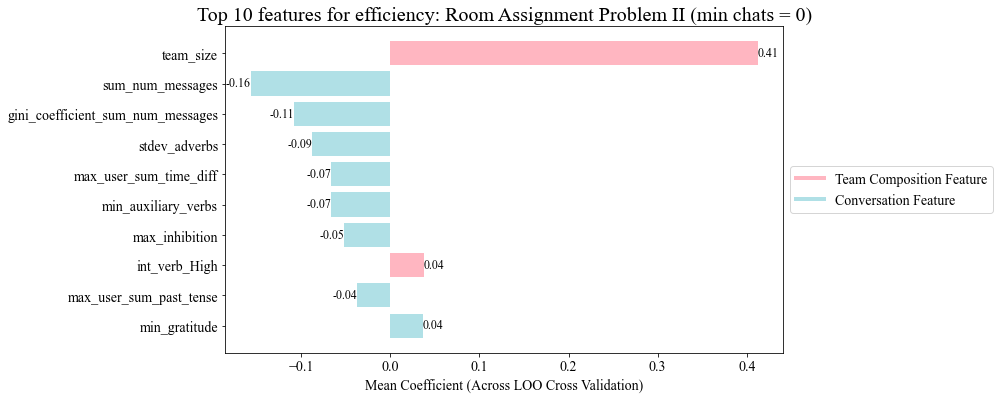

In [61]:
plot_top_n_features(display_feature_coefficients(mlall_feature_coefficients), 10, filepath = "./figures/csopII" + "_" + desired_target + "_min_chat_num_" + str(min_num_chats))

Questions:
- More deeply understand difference between LASSO and Ridge
- Better understand `alpha` hyperparameter
- Why doesn't more features mean a better R^2? (Wouldn't the model 'throw out' features that don't work?)

## "Out of Sample" Testing (Using CSOP I)

TODO -- the cold below is old; if we do out of sample testing, we need to hook this up with CSOP 1!

In [62]:
# # Preprocess CSOP 2 to look like CSOP 1
# csop2_path = data_path + 'conv/csopII_output_conversation_level.csv'
# csop2_conv_data  = pd.read_csv(csop2_path)

# csop2_conv_data = csop2_conv_data[csop2_conv_data["sum_num_messages"] >= min_num_chats]

In [63]:
# # Test only on the case where the team size = 3
# csop2_conv_data = csop2_conv_data[csop2_conv_data["team_size"] == 3]

In [64]:
# # First, get the task features
# csop2_conv_data["difficulty"] = csop2_conv_data["difficulty"].map({
#     "Easy [Corresponds to 'Hard' in PNAS]": "Moderate",
#     "Hard [Corresponds to 'Super Hard' in PNAS]": "Very high"
# })
# task_features_test = csop2_conv_data["difficulty"]


In [65]:
# task_features_test = pd.get_dummies(csop2_conv_data["difficulty"])
# task_features_test["High"] = 0
# task_features_test["Low"] = 0
# task_features_test["Very low"] = 0
# task_features_test = task_features_test[task_features.columns]

Composition Features
- team_size: Team Size (1-10)
- soc_pers: Social Perceptiveness * (this is the only thing in common with CSOP 1)
- vis_img: Visual Imagery
- int_verb: Internal Verbalization
- ort_img: Orthographic Imagery
- rep_man: Representational Manipulation

The problem is that all these are categorical (e.g., "High", "Mixed", "Low") --- can't be used

In [66]:
# team_composition_features_test = csop2_conv_data[["int_verb", "vis_img", "ort_img", "rep_man", "soc_pers", "team_size"]]

In [67]:
# def drop_non_common_columns(dfs):
# 	"""
# 	Drops any columns that are not shared between dataframes,
# 	so that they can be plotted on the same axis.

# 	@param dfs: list of dataframes
# 	"""

# 	# Check if there are any data frames in the list
# 	if not dfs:
# 		return []

# 	# Find the intersection of columns in all data frames
# 	common_columns = set(dfs[0].columns)
# 	for df in dfs[1:]:
# 		common_columns = common_columns.intersection(df.columns)

# 	# Create a new list of data frames with only common columns
# 	new_data_frames = []
# 	for df in dfs:
# 		new_data_frames.append(df[list(common_columns)])

# 	return new_data_frames

In [68]:
# # possible targets to try
# targets_test = csop2_conv_data[["efficiency","score","duration"]]
# targets_test = pd.DataFrame(StandardScaler().fit_transform(targets_test), columns = targets_test.columns)

# # Read in the config file and use that the drop the extraneous columns
# with open('./config.json', "rb") as json_file:
#     config = json.load(json_file)

# conv_features_test = csop2_conv_data.drop(config["csopII"]['cols_to_ignore'], axis = 1)

In [69]:
# # Normalization
# conv_features_test = pd.DataFrame(StandardScaler().fit_transform(conv_features_test), columns = conv_features_test.columns)
# # drop na cols
# conv_features_test = conv_features_test.dropna(axis = 1)

In [70]:
# drop cols that aren't in csop I and reorder them the match
# _ , conv_features_test = drop_non_common_columns([conv_features, conv_features_test])
# conv_features_test = conv_features_test[conv_features.columns]

In [71]:
# X_test = pd.concat([task_features_test.reset_index(drop=True), conv_features_test.reset_index(drop=True)], axis=1)

## Pass the desired trained model in from the earlier steps

In [72]:
# out_of_sample_test_results = pd.DataFrame(
#     {
#         "model": [],
#         "features_included": [],
#         "r2": [],
#         "rmse": []
#     }
# )

# models = [model_lasso_task, model_lasso_tconv, model_lasso_comms]
# features = ["Task Complexity", "Task Complexity + Communication", "Communication"]
# feature_lists = [list(task_features_test.columns), list(task_features_test.columns) + list(conv_features_test.columns), list(conv_features_test.columns)]

# for i in range(len(models)):
#     model = models[i]
#     feature = features[i]
#     feature_list = feature_lists[i]

#     r2 = r2_score(y_true=targets_test[desired_target], y_pred=model.predict(X_test[feature_list])).round(4)
#     rmse = np.sqrt(mean_squared_error(y_true=targets_test[desired_target], y_pred=model.predict(X_test[feature_list])).round(4)).round(4)
#     out_of_sample_test_results = pd.concat([out_of_sample_test_results, pd.DataFrame({"model": [model], "features_included": [feature], "r2": [r2], "rmse": [rmse]})], ignore_index=True)

In [73]:
# out_of_sample_test_results

In [74]:
# directory = os.path.dirname(test_results_output_name)
# if not os.path.exists(directory):
#     os.makedirs(directory)
# out_of_sample_test_results.sort_values(by = "r2", ascending = False).to_csv(test_results_output_name)